# Exploratory Data Analysis
Some simple EDA to get to know our dataset.

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import pickle as p

In [3]:
df = pd.read_csv('../data/HR_comma_sep.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


## Looking at the values taken by the two categorical features:

In [4]:
print(df.sales.value_counts())
print('---')
print(df.salary.value_counts())

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: sales, dtype: int64
---
low       7316
medium    6446
high      1237
Name: salary, dtype: int64


## Comparing churn among different departments:

In [5]:
positions = df.sales.value_counts().index
for pos in positions:
    temp = df[df.sales == '{}'.format(pos)]
    print('Dept: {} || Churn Rate: {}\n'.format(pos,round(temp['left'].sum()/temp.shape[0],3)))

Dept: sales || Churn Rate: 0.245

Dept: technical || Churn Rate: 0.256

Dept: support || Churn Rate: 0.249

Dept: IT || Churn Rate: 0.222

Dept: product_mng || Churn Rate: 0.22

Dept: marketing || Churn Rate: 0.237

Dept: RandD || Churn Rate: 0.154

Dept: accounting || Churn Rate: 0.266

Dept: hr || Churn Rate: 0.291

Dept: management || Churn Rate: 0.144



# A Couple Notes:

* The main takeaway here is that we are clearly dealing with imbalanced classes! We'll have to take this into consideration when building our model.  


* R & D and Management stick out as two departments with slightly less turnover, but likely not to the extent they deserve special, or exclusive consideration.  Let's simply consider inclusion in any of these departments as a feature in our feature space.  Here, we use one hot encoding to reformat the departments - as well as the salary levels - as numeric features:

In [6]:
fs = pd.get_dummies(df, prefix=[None,'sal'],columns=['sales','salary'])
fs.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,IT,RandD,...,hr,management,marketing,product_mng,sales,support,technical,sal_high,sal_low,sal_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


## Let's try to get a sense of feature importance using a couple basic, out-of-box classifiers:

##### The SMOTE class from imbalanced-learning, a scikit-learn contrib package, uses the synthetic minority oversampling technique (SMOTE) to account for class imbalance in our target data.

In [7]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE 

##### Defining our target y, the 'left' column, and our feature space X.  Then we create train/test sets, and finally, we fix our class imbalance problem with SMOTE resampling:

In [8]:
copy = fs.copy()

y = copy.pop('left')
X = copy

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=23)
X_train, y_train = SMOTE().fit_sample(X_train,y_train)

##### Truly out of the box - all default parameters!

In [9]:
model_forest = RandomForestClassifier(random_state=23)
model_extra = ExtraTreesClassifier(random_state=23)
model_boost = AdaBoostClassifier(random_state=23)

models = [model_forest,model_extra,model_boost]

##### Here we create features_dict, a dictionary containing our features as keys, and populate it with each feature's cumulative feature importance from the three models.  Once the dictionary is filled, we plot the results on a simple bar graph:

<Container object of 21 artists>

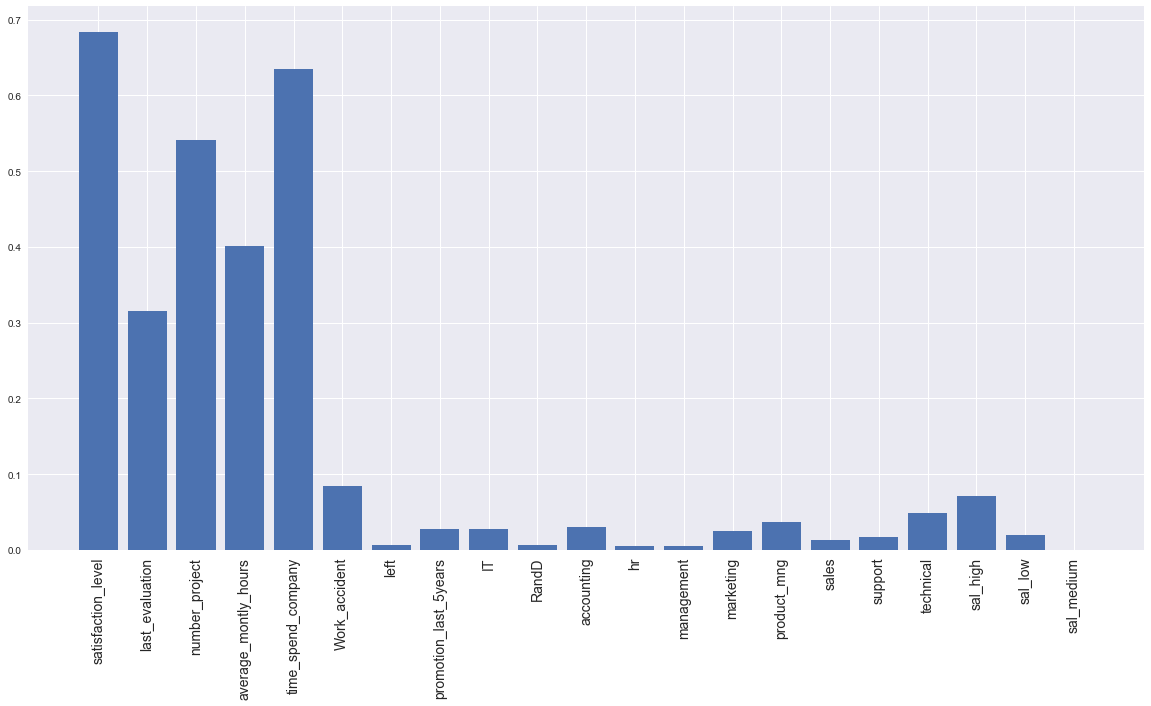

In [10]:
features_dict = {x:0 for x in fs.columns}

def get_feature_importances(model):
    model.fit(X_train,y_train)
    for idx,imp in enumerate(model.feature_importances_):
        features_dict[fs.columns[idx]] += imp
        
for model in models:
    get_feature_importances(model)
    
x_axis = range(0,len(fs.columns))

plt.figure(figsize=(20,10))
plt.xticks(x_axis,features_dict.keys(), rotation='vertical',fontsize=14)
plt.bar(x_axis,features_dict.values())

Wow! The results themselves aren't too surprising - things like satisfaction level, time spent at the company, et cetera are all things we'd expect to have a sizable impact on employee retention - however, the disparity between the collective importance of the first 5 features versus that of the following 15 is *pronounced*.  Perhaps the most interesting observation we can make here is that employee turnover seems to happen fairly uniformly across departments as well as salary levels.  
  
  
  Let's explore our 5 most important features a little more:

##### Creating a dataframe containing the 5 features + the target feature:

In [14]:
imp = ['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company','left']
idf = fs[imp]

# Let's also serialize this list for use in other notebooks!
p.dump(imp,open('../data/f.pkl','wb'))

##### Looking at pairwise plots of our feature space - it's a little messy-looking initially, but using the lines of best fit helps us to get a better idea of possible correlations between features:

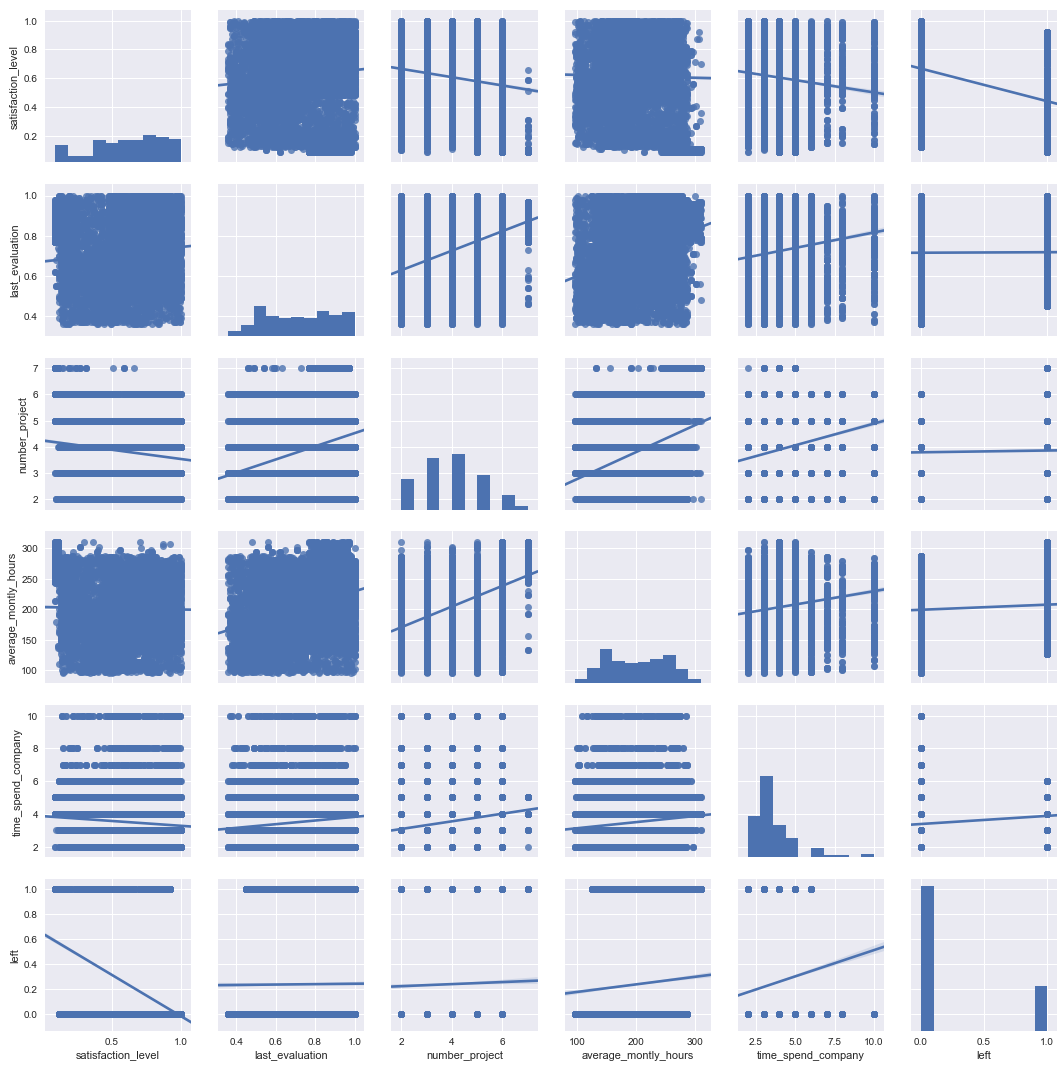

In [11]:
sns.set_style('darkgrid')
plot = sns.pairplot(idf,diag_kind='hist',kind='reg')

# Takeaways:
1. Unsurprisingly, satisfaction level is negatively correlated with employee churn - happier employees are less likely to leave.
2. Time spent at the company is positively correlated with last evaluation score, number of projects, and monthly hours.  These all make sense as well.  Concerningly (though also, perhaps, expectedly) time spent at the company is negatively correlated with satisfaction level.  
3.  The group of employees who have completed 7 projects sticks out as very easy to qualify: while the time spent at company feature is skewed towards the inexperienced end, this group in particular appears to be composed exclusively of more junior employees.  They work more hours than other groups, they tend to score very well on their evaluations, and they tend towards dissatisfaction in their jobs.  Most of these workers fall in the 'low' salary category:

In [12]:
df[df.number_project == 7].salary.value_counts()

low       144
medium    109
high        3
Name: salary, dtype: int64

**To get a better sense of the *strength* of these correlations, let's look at some heatmaps:**

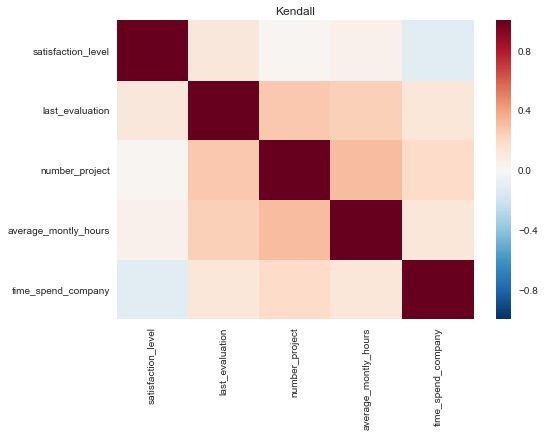

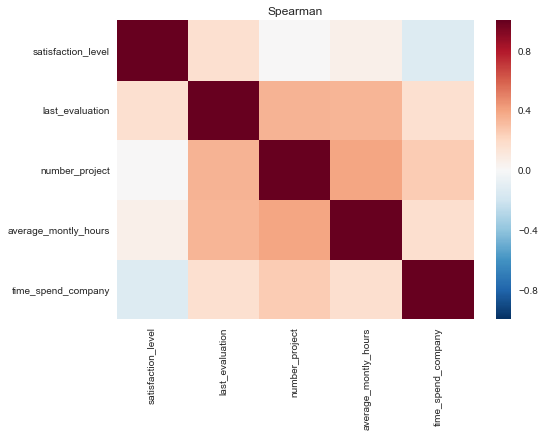

In [13]:
correlation = idf.drop('left',axis=1).corr(method='kendall')
correlation2 = idf.drop('left',axis=1).corr(method='spearman')

plt.title('Kendall')
sns.heatmap(correlation)
plt.figure()
plt.title('Spearman')
sns.heatmap(correlation2)

###### We can confirm that time spent at the company and satisfaction level are negatively correlated, though the two seem to be fairly weakly-correlated with any of the other features.  Number of projects, last evaluation score, and average monthly hours are all fairly correlated to one another - we should experiment with some feature and/or dimension reduction when it comes time to build a model!